# Bayes In Action 😎

**A quick recap of our journey so far**:

1. We conducted an in-depth analysis of the marketing investment dataset, successfully addressing the "when" question by identifying lag effects and timing dynamics.

2. We tried a multivariate regression model to estimate coefficients, aiming to answer the "how" question and use the model for future predictions. However, this approach revealed a critical challenge: The presence of highly correlated variables made our model unreliable for interpreting relationships and predicting accurately. Collinearity undermined our ability to provide a clear and reliable answer to the "how" question, and it put the validity of our predictions at risk.

3. Gabriele proposed leveraging Bayesian linear regression to address multicollinearity. By incorporating prior knowledge through carefully designed priors, we can stabilize our estimates and improve the reliability of our model.

4. Lele introduced us to a Python library that enables us to implement Bayesian linear regression easily. He even shared a tutorial to guide us through the process!

**What’s Next?**

We now have all the necessary ingredients:

1. A deep understanding of our data.
2. A clear problem to solve (multicollinearity).
3. A solution framework (Bayesian linear regression).
4. The tools and knowledge to implement it.

 💪 Bayesian modeling, here we come!








## Set Up & Read Data 🗞

In [7]:
from typing import List

import pymc
import arviz
import pytensor.tensor as pt
from scipy.stats import kstest, lognorm, norm, beta, truncnorm, halfnorm, ks_1samp
import scipy.stats as stats

from typing import Any
from pymc.distributions.dist_math import check_parameters


import plotly.graph_objects as go
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from ipywidgets import FloatSlider, interactive, VBox, HBox, Checkbox, FloatText
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive
from google.colab import output
import plotly.figure_factory as ff
import pytensor.tensor as pt
from pytensor.scan import scan



import polars as pl
import numpy as np
import plotly.express as px
from sklearn.metrics import r2_score, mean_absolute_error

import plotly.graph_objects as go

In [8]:
import plotly.io as pio
pio.templates.default = 'plotly_white'
output.enable_custom_widget_manager()


In [9]:
path = '/content/mmm_data_for_regression.parquet'
df = pl.read_parquet(path).sort('Monday')

df.head(4)

Monday,New Customers (gross),Promo € New Cust.,PPC Brand €,PPC Generic €,Facebook €,Instagram €,year,week,Promo € New Cust._lag0,PPC Brand €_lag0,PPC Generic €_lag3,Facebook €_lag2,Instagram €_lag6,time,sin_52_1,cos_52_1,sin_52_2,cos_52_2
date,i64,f64,f64,f64,f64,f64,i32,i8,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64
2020-05-18,777,1304.227029,756.818857,1512.071585,297.193399,4593.059512,2020,21,1304.227029,756.818857,2300.295763,999.081772,82.890357,113,0.885456,0.464723,0.822984,-0.568065
2020-05-25,978,3000.504127,69.654279,399.82446,0.0,792.564928,2020,22,3000.504127,69.654279,4268.329032,637.97411,1246.32403,114,0.935016,0.354605,0.663123,-0.748511
2020-06-01,950,4609.816216,357.467625,471.992936,1769.420849,3281.127107,2020,23,4609.816216,357.467625,4219.098648,297.193399,1969.201111,115,0.970942,0.239316,0.464723,-0.885456
2020-06-08,800,3429.065037,425.663469,1181.626485,2353.024023,4510.560793,2020,24,3429.065037,425.663469,1512.071585,0.0,2889.605271,116,0.992709,0.120537,0.239316,-0.970942


In [10]:
rename_columns = {
    'New Customers (gross)': 'new_customers',
    'Promo € New Cust._lag0': 'promo_lag0',
    'PPC Brand €_lag0': 'ppc_brand_lag0',
    'PPC Generic €_lag3': 'ppc_generic_lag3',
    'Facebook €_lag2': 'facebook_lag2',
    'Instagram €_lag6': 'instagram_lag6'
}

df = df.rename(rename_columns)

In [11]:
target = 'new_customers'
date_col = 'Monday'
raw_regressors = ['promo_lag0',
 'ppc_brand_lag0',
 'ppc_generic_lag3',
 'facebook_lag2',
 'instagram_lag6',
 'time',
 'sin_52_1',
 'cos_52_1',
 'sin_52_2',
 'cos_52_2']

## Bayesian Model Definition 💠

$$
y(t) \mid \mu(t), \sigma \sim N(\mu(t), \sigma),
$$

where:

$$
 \quad \sigma \sim P(\sigma).
$$

And we can be a little bit more precise about $\mu(t)$

$$
\mu(t) = \alpha + k  t + \sum_{i=1}^n \left[\alpha_i \sin\left(\frac{2 \pi i}{52} t\right) + \beta_i \cos\left(\frac{2 \pi i}{52} t\right)\right]
+ \gamma_1  \text{saturation}(\text{Promo}(t), \delta)
+ \gamma_2  \text{adstock}(\text{PPC_brand}(t), \lambda_1)
+ \gamma_3  \text{adstock}(\text{PPC_generic}(t-3), \lambda_2)
+ \gamma_4  \text{adstock}(\text{Facebook}(t-2), \lambda_3)
+ \gamma_5  \text{adstock}(\text{Instagram}(t-6), \lambda_4)
$$

where

$$
\alpha \sim P(\alpha)
$$
$$
k \sim P(k)
$$
$$
\alpha_i \sim P(\alpha_i), \quad \beta_i \sim P(\beta_i)
$$
$$
\gamma_i \sim P(\gamma_i)
$$
$$
\delta \sim P(\delta), \quad \lambda_i \sim P(\lambda_i)
$$

### How Do We Choose the Priors? 😅


Choosing priors combines insights from frequentist linear regression as a starting point with domain knowledge to guide and refine decisions. For further details, you can refer to the excellent guide: [Stan Prior Choice Recommendations](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations)


Key Suggestions for Choosing Priors:

1. **Standardizing variables** is generally a good practice because it simplifies the specification of priors and improves model performance. By rescaling the predictors priors can be defined more intuitively and consistently across variables, as they operate on a standardized scale. Additionally, standardization enhances the efficiency of sampling methods like MCMC, as it ensures better numerical stability and smoother posterior distributions, leading to faster convergence and more reliable optimization.


2. **Flat Priors**. To be AVOIDED!

2. **Weakly Informative Priors**. Use these when strong domain knowledge is lacking, but you still want to avoid uninformative priors. They constrain parameters within reasonable ranges, stabilize estimation, prevent overfitting, and provide a practical starting point for model building without dominating the posterior.

3. **Specific Informative Priors**. Leverage these when you have reliable prior information or strong domain expertise, particularly for small or noisy datasets, well-studied phenomena, or when constraining parameters to realistic and meaningful bounds.




In [12]:
alpha_widget = widgets.IntSlider(value=2,
    min=1,
    max=10,
    step=1,
    description='alpha')

beta_widget = widgets.IntSlider(value=2,
    min=1,
    max=10,
    step=1,
    description='beta')

def plot_beta_distribution(alpha, beta_param):

    # Calculate mean and standard deviation
    mean = alpha / (alpha + beta_param)
    std_dev = np.sqrt((alpha * beta_param) / ((alpha + beta_param)**2 * (alpha + beta_param + 1)))

    # Generate x values
    x = np.linspace(0, 1, 500)

    # Generate PDF and CDF values
    pdf_values = beta.pdf(x, alpha, beta_param)
    cdf_values = beta.cdf(x, alpha, beta_param)

    # Create the figure with both plots
    fig = go.Figure()

    # Add the PDF plot
    fig.add_trace(go.Scatter(
        x=x, y=pdf_values,
        mode='lines',
        name='PDF',
        line=dict(color='blue'),
        fill='tozeroy',
        hovertemplate='x: %{x:.2f}<br>PDF: %{y:.2f}'
    ))

    # Add the CDF plot
    fig.add_trace(go.Scatter(
        x=x, y=cdf_values,
        mode='lines',
        name='CDF',
        line=dict(color='orange', dash='dot'),
        hovertemplate='x: %{x:.2f}<br>CDF: %{y:.2f}'
    ))

    # Add annotations for mean and std deviation
    fig.add_trace(go.Scatter(
        x=[mean], y=[beta.pdf(mean, alpha, beta_param)],
        mode='markers+text',
        name='Mean',
        text=[f"Mean: {mean:.2f}\nStd Dev: {std_dev:.2f}"],
        textposition='top right',
        marker=dict(color='red', size=10)
    ))

    # Layout adjustments
    fig.update_layout(
        title=f"Beta Distribution (\u03B1={alpha}, \u03B2={beta_param})",
        xaxis_title="x",
        yaxis_title="Density / Cumulative Probability",
        width=1300, height=600
    )

    # Show the plot
    fig.show()

# Example usage
#plot_beta_distribution(alpha=2, beta_param=5)



In [13]:
std_half_widget = widgets.FloatSlider(
    value=1, min=0.01, max=10, step=0.1, description="Std Dev"
)

def plot_halfnormal_distribution(std: float):
    std = np.round(std, 2)
    if std <= 0:
        raise ValueError("Standard deviation must be positive.")

    # Define the x range (only positive side for Half-Normal)
    x = np.linspace(0, 4 * std, 500)

    # Calculate PDF and CDF using scipy.stats.halfnorm
    pdf = halfnorm.pdf(x, scale=std)
    cdf = halfnorm.cdf(x, scale=std)

    # Create the plotly figure
    fig = go.Figure()

    # Add PDF to the plot
    fig.add_trace(
        go.Scatter(
            x=x, y=pdf, mode="lines", name="PDF",
            line=dict(color="blue"),
            fill="tozeroy",
            hovertemplate="<b>PDF</b>: %{y:.4f}<br><b>X</b>: %{x:.2f}<extra></extra>",
        )
    )

    # Add CDF to the plot
    fig.add_trace(
        go.Scatter(
            x=x, y=cdf, mode="lines", name="CDF",
            line=dict(color="green", dash="dash"),
            hovertemplate="<b>CDF</b>: %{y:.4f}<br><b>X</b>: %{x:.2f}<extra></extra>",
        )
    )

    # Add annotations for mean and std deviation
    mean = std * np.sqrt(2 / np.pi)  # Mean of the Half-Normal distribution
    fig.add_trace(
        go.Scatter(
            x=[mean],
            y=[halfnorm.pdf(mean, scale=std)],
            mode="markers",
            name="Mean",
            marker=dict(color="red", size=10, symbol="x"),
            hovertemplate=f"<b>Mean</b>: {mean:.4f}<extra></extra>",
        )
    )

    # Update layout
    fig.update_layout(
        title=f"Half-Normal Distribution (std={std})",
        xaxis_title="X",
        yaxis_title="Density",
        legend=dict(title="Legend", orientation="h", y=-0.2),
        template="plotly_white",
        width=1300, height=600,
    )

    # Show the plot
    fig.show()


In [14]:


# Widgets for Mean & Standard Deviation
mean_widget = FloatSlider(value=0, min=-1, max=1, step=0.1, description="Mean")
std_widget = FloatSlider(value=1, min=0.1, max=10, step=0.1, description="Std Dev")

# Widgets for Lower & Upper Bounds (Truncation)
lower_bound_widget = FloatText(value=None, placeholder="Lower Bound", description="Lower")
upper_bound_widget = FloatText(value=None, placeholder="Upper Bound", description="Upper")

# Checkbox to Enable/Disable Truncation
truncated_widget = Checkbox(value=False, description="Truncated")

# Function to Plot Normal & Truncated Normal Distributions
def plot_normal_distribution(mean, std, lower=None, upper=None, truncated=False):
    mean = np.round(mean, 2)
    std = np.round(std, 2)

    # Define x range for plotting
    x_min, x_max = mean - 4 * std, mean + 4 * std

    if truncated:
        if lower is not None:
            x_min = max(x_min, lower - 1)
        if upper is not None:
            x_max = min(x_max, upper + 1)

    x = np.linspace(x_min, x_max, 1000)

    if truncated and (lower is not None or upper is not None):
        # Truncated Normal Distribution
        a, b = -np.inf, np.inf
        if lower is not None:
            a = (lower - mean) / std
        if upper is not None:
            b = (upper - mean) / std

        pdf_values = truncnorm.pdf(x, a, b, loc=mean, scale=std)
        cdf_values = truncnorm.cdf(x, a, b, loc=mean, scale=std)  # ✅ Corrected CDF
        title = "Truncated Normal Distribution"
    else:
        # Regular Normal Distribution
        pdf_values = norm.pdf(x, loc=mean, scale=std)
        cdf_values = norm.cdf(x, loc=mean, scale=std)  # ✅ Corrected CDF
        title = "Normal Distribution"

    # Create Figure
    fig = go.Figure()

    # Add PDF (Probability Density Function)
    fig.add_trace(go.Scatter(x=x, y=pdf_values, mode="lines", name="PDF", fill="tozeroy",
                             line=dict(color="blue"), opacity=0.5))

    # Add CDF (Cumulative Distribution Function)
    fig.add_trace(go.Scatter(x=x, y=cdf_values, mode="lines", name="CDF",
                             line=dict(color="green", dash="dash")))

    # Add Mean Marker
    fig.add_trace(go.Scatter(x=[mean], y=[max(pdf_values)], mode="markers",
                             name="Mean", marker=dict(color="red", size=10, symbol="x")))

    # Update Layout (Fixed Y-axis at 1)
    fig.update_layout(
        title=title + f" (mean={mean}, std={std})",
        xaxis_title="Value",
        yaxis_title="Density",
        yaxis=dict(range=[0, 2.3]),  # Fixed y-axis for better comparison
        legend=dict(title="Legend", orientation="h", y=-0.2),
        width=1300, height=600
    )

    fig.show()



### 📌 Beta Distribution Definition
The Beta distribution is defined as:

$$
f(x; \alpha, \beta) = \frac{x^{\alpha - 1} (1 - x)^{\beta - 1}}{B(\alpha, \beta)}
$$

where:
- $\alpha > 0$ and $beta > 0$ are the shape parameters.
- $B(\alpha, \beta)$ is the **Beta function**, defined as:

$$
B(\alpha, \beta) = \int_0^1 t^{\alpha - 1} (1 - t)^{\beta - 1} dt
$$


$$\mu = \frac{\alpha}{\alpha + \beta}$$

$$\sigma = \sqrt{ \frac{\alpha \beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)} }$$


In [15]:
interactive_beta_plot = interactive(
    plot_beta_distribution,
    alpha=alpha_widget,
    beta_param=beta_widget,
)

display(interactive_beta_plot)

interactive(children=(IntSlider(value=2, description='alpha', max=10, min=1), IntSlider(value=2, description='…

### 📌 Normal Distribution Definition
The Normal (Gaussian) distribution is defined as:

$$
f(x; \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(x - \mu)^2}{2\sigma^2}}
$$

















In [16]:
interactive_normal_plot = interactive(
    plot_normal_distribution,
    mean=mean_widget,
    std=std_widget,
    lower=lower_bound_widget,
    upper=upper_bound_widget,
    truncated=truncated_widget,
)

display(interactive_normal_plot)

interactive(children=(FloatSlider(value=0.0, description='Mean', max=1.0, min=-1.0), FloatSlider(value=1.0, de…

### 📌 Half-Normal Distribution Definition

The Half-Normal distribution is derived from the normal distribution, considering only the positive half:

$$
f(x; \sigma) = \frac{\sqrt{2}}{\sigma \sqrt{\pi}} e^{-\frac{x^2}{2\sigma^2}}, \quad x \geq 0
$$

$$\mu = \sigma \sqrt{\frac{2}{\pi}}$$


In [17]:
interactive_halfnormal_plot = interactive(
    plot_halfnormal_distribution,
    std=std_half_widget,
)

display(interactive_halfnormal_plot)

interactive(children=(FloatSlider(value=1.0, description='Std Dev', max=10.0, min=0.01), Output()), _dom_class…

### The Model In practise 👷

📌 **Standardization**


To ensure a well-scaled dataset, we will apply Min-Max standardization. This transformation rescales all features to a [0,1] range, eliminating negative values and maintaining interpretability.

We choose Min-Max scaling because:
- It aligns well with our dataset, as we do not expect extreme outliers.
- It maintains the original distribution shape, unlike Z-score normalization.
- It ensures all features have the same scale, improving model stability.

⚠️ Caution: Min-Max scaling is sensitive to outliers, which can compress the majority of data into a small range. If our dataset contained extreme values, alternative methods (such as robust scaling) might be preferable.

In [19]:
import polars as pl

def standardize_columns(
    df: pl.DataFrame,
    columns: list[str]
) -> tuple[pl.DataFrame, dict[str, tuple[float, float]]]:

    min_max_dict = {}
    exprs = []

    for col in columns:
        col_min = df[col].min()
        col_max = df[col].max()
        min_max_dict[col] = (col_min, col_max)

        standardized_expr = (
            ((pl.col(col) - col_min) / (col_max - col_min)).alias(f"{col}_standardized")
        )
        exprs.append(standardized_expr)

    standardized_df = df.with_columns(exprs)

    return standardized_df, min_max_dict

def reverse_standardize(
    df: pl.DataFrame,
    columns: list[str],
    min_max_dict: dict[str, tuple[float, float]]
) -> pl.DataFrame:

    exprs = []

    for col in columns:
        col_original = col.replace("_standardized", "")
        col_min, col_max = min_max_dict[col_original]

        reversed_expr = (
            (pl.col(col) * (col_max - col_min) + col_min).alias(col_original)
        )
        exprs.append(reversed_expr)

    reversed_df = df.with_columns(exprs)

    return reversed_df

In [20]:
cols_to_standarise = [target] + raw_regressors
standarised_df, standardisation_dict = standardize_columns(df, cols_to_standarise)

In [21]:
standarised_df.columns

['Monday',
 'new_customers',
 'Promo € New Cust.',
 'PPC Brand €',
 'PPC Generic €',
 'Facebook €',
 'Instagram €',
 'year',
 'week',
 'promo_lag0',
 'ppc_brand_lag0',
 'ppc_generic_lag3',
 'facebook_lag2',
 'instagram_lag6',
 'time',
 'sin_52_1',
 'cos_52_1',
 'sin_52_2',
 'cos_52_2',
 'new_customers_standardized',
 'promo_lag0_standardized',
 'ppc_brand_lag0_standardized',
 'ppc_generic_lag3_standardized',
 'facebook_lag2_standardized',
 'instagram_lag6_standardized',
 'time_standardized',
 'sin_52_1_standardized',
 'cos_52_1_standardized',
 'sin_52_2_standardized',
 'cos_52_2_standardized']

In [22]:
st_target = 'new_customers_standardized'
st_raw_regressors = [f'{col}_standardized' for col in raw_regressors]

In [23]:
st_channels = ['promo_lag0_standardized',
 'ppc_brand_lag0_standardized',
 'ppc_generic_lag3_standardized',
 'facebook_lag2_standardized',
 'instagram_lag6_standardized']

## Build The Model With PyMC 🏛


Now that we have outlined all the components of our Bayesian model, we are ready to implement it using the PyMC framework.

In [24]:
train_df = standarised_df.sort(date_col).select([date_col, target, st_target] + st_raw_regressors)

#### Pytensor Utilities

In [25]:

class ConvMode(str):
    """Convolution mode for the convolution."""
    After = "After"
    Before = "Before"
    Overlap = "Overlap"


def batched_convolution(
    x: pt.TensorLike,
    w: pt.TensorLike,
    axis: int = 0,
    mode: ConvMode | str = ConvMode.After,
) -> pt.TensorVariable:

    orig_ndim = x.ndim
    axis = axis if axis >= 0 else orig_ndim + axis
    w = pt.as_tensor(w)
    x = pt.moveaxis(x, axis, -1)
    l_max = w.type.shape[-1]
    if l_max is None:
        try:
            l_max = w.shape[-1].eval()
        except Exception:
            pass

    x_time = x.shape[-1]
    x_shape = x.shape

    shape = (*x_shape[:-1], x_shape[-1] + w.shape[-1] - 1, w.shape[-1])
    padded_x = pt.zeros(shape, dtype=x.dtype)

    if l_max is None:  # pragma: no cover
        raise NotImplementedError(
            "Convolving with weight arrays that don't have a concrete shape is not supported."
        )
    if l_max <= 1:
        window = slice(None)
    elif mode == ConvMode.Before:
        window = slice(l_max - 1, None)
    elif mode == ConvMode.After:
        window = slice(None, -l_max + 1)
    elif mode == ConvMode.Overlap:
        window = slice((l_max // 2) - (1 if l_max % 2 == 0 else 0), -(l_max // 2))
    else:
        raise ValueError(f"Invalid Mode: {mode}, expected one of {ConvMode}")

    for i in range(l_max):
        padded_x = pt.set_subtensor(padded_x[..., i : x_time + i, i], x)

    padded_x = padded_x[..., window, :]
    conv = pt.sum(padded_x * w[..., None, :], axis=-1)

    return pt.moveaxis(conv, -1, axis + conv.ndim - orig_ndim)


def geometric_adstock_pytensor(
    x: pt.TensorLike,
    alpha: float = 0.5,
    l_max: int = 12,
    normalize: bool = False,
    axis: int = 0,
    mode: ConvMode = ConvMode.After,
) -> pt.TensorVariable:

    # Ensure alpha is valid
    alpha = check_parameters(
        alpha, [pt.ge(alpha, 0), pt.lt(alpha, 1)], msg="0 <= alpha < 1"
    )

    # Create geometric weights
    w = pt.power(pt.as_tensor(alpha)[..., None], pt.arange(l_max, dtype=x.dtype))
    w = w / pt.sum(w, axis=-1, keepdims=True) if normalize else w

    # Perform convolution
    return batched_convolution(x, w, axis=axis, mode=mode)


def root_transformation_pytensor(
    x: pt.TensorLike,
    alpha: pt.TensorLike,
) -> pt.TensorVariable:
    return x**alpha

def apply_saturation_and_adstock(
    x: pt.TensorLike,
    saturation_param: pt.TensorLike,
    adstock_param: pt.TensorLike,

) -> pt.TensorVariable:

  return geometric_adstock_pytensor(
      root_transformation_pytensor(x, saturation_param), adstock_param)

#### Pymc Model

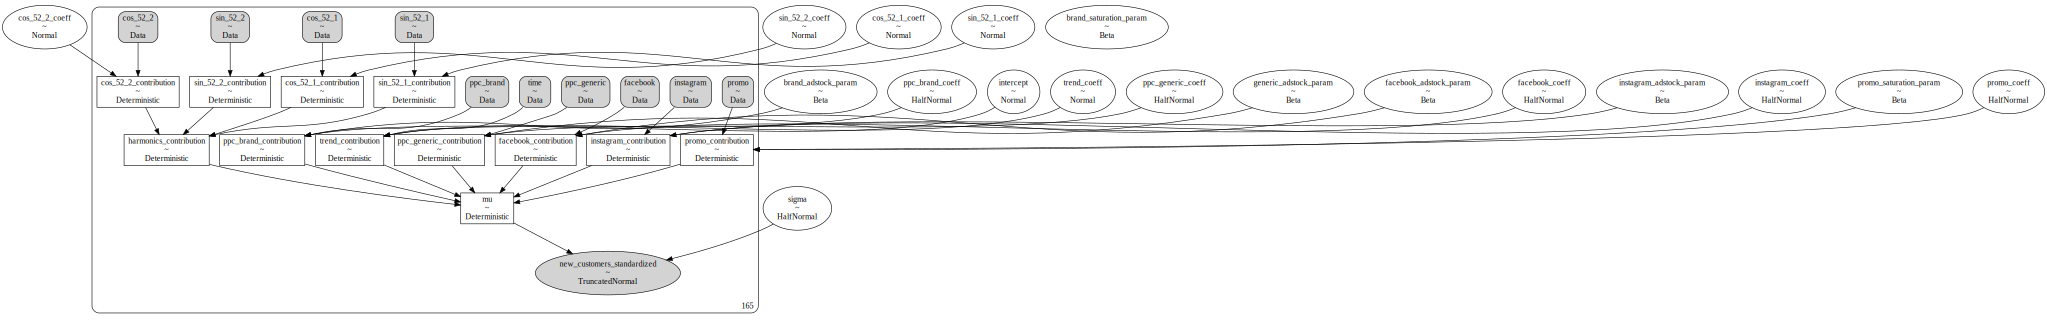

In [26]:
uninformative_coeff_std = 1
halfnormal_std = 0.5

with pymc.Model() as model:
  # standard deviation
  sigma = pymc.HalfNormal("sigma", sigma=uninformative_coeff_std)

  # intercept
  intercept = pymc.Normal("intercept", mu=0, sigma=uninformative_coeff_std)

  # trend
  trend_coeff = pymc.Normal("trend_coeff", mu=0, sigma=uninformative_coeff_std)
  trend_data = pymc.Data("time", train_df['time_standardized'].to_list())
  trend = pymc.Deterministic(name='trend_contribution', var=intercept + trend_coeff * trend_data)

  # seasonality
  harm_vars = []
  harmonic_cols = [col for col in st_raw_regressors if ('sin_' in col) | ('cos_' in col )]
  for harmonic_col in harmonic_cols:
    harmonic_col_name = harmonic_col.replace('_standardized', '')
    harm_coeff = pymc.Normal(f"{harmonic_col_name}_coeff", mu=0, sigma=uninformative_coeff_std)
    harm_data = pymc.Data(harmonic_col_name, train_df[harmonic_col].to_list())
    harm_vars.append(pymc.Deterministic(name=f'{harmonic_col_name}_contribution', var=harm_coeff * harm_data))
  harmonics = pymc.Deterministic(name='harmonics_contribution', var=sum(harm_vars))

  # promotions
  #saturation_param = pymc.TruncatedNormal(name="saturation_param", mu=0.5, sigma=0.2, lower=0.1, upper=0.9)
  promo_saturation_param = pymc.Beta(name="promo_saturation_param", alpha=2, beta=8)
  promo_coeff = pymc.HalfNormal('promo_coeff', sigma=halfnormal_std)
  promo_data = pymc.Data("promo", train_df['promo_lag0_standardized'].to_list())
  transformed_promo = root_transformation_pytensor(promo_data, promo_saturation_param)
  promo = pymc.Deterministic(name='promo_contribution', var=promo_coeff * transformed_promo)

  # ppc brand
  #ppc_brand_adstock_param = pymc.TruncatedNormal(name="brand_adstock_param", mu=0.5, sigma=0.1, lower=0, upper=0.8)
  ppc_brand_adstock_param = pymc.Beta(name="brand_adstock_param", alpha=8, beta=8)
  ppc_brand_saturation_param = pymc.Beta(name="brand_saturation_param", alpha=8, beta=8)
  ppc_brand_coeff = pymc.HalfNormal('ppc_brand_coeff', sigma=halfnormal_std)
  ppc_brand_data = pymc.Data("ppc_brand", train_df['ppc_brand_lag0_standardized'].to_list())
  transformed_brand =  geometric_adstock_pytensor(ppc_brand_data, ppc_brand_adstock_param)
  ppc_brand = pymc.Deterministic(name='ppc_brand_contribution', var=ppc_brand_coeff * transformed_brand)


  # ppc generic
  #ppc_generic_adstock_param = pymc.TruncatedNormal(name="generic_adstock_param", mu=0.5, sigma=0.1, lower=0, upper=0.8)
  ppc_generic_adstock_param =  pymc.Beta(name="generic_adstock_param", alpha=8, beta=2)
  ppc_generic_coeff = pymc.HalfNormal('ppc_generic_coeff',sigma=halfnormal_std)
  ppc_generic_data = pymc.Data("ppc_generic", train_df['ppc_generic_lag3_standardized'].to_list())
  ppc_generic = pymc.Deterministic(name='ppc_generic_contribution', var=ppc_generic_coeff * geometric_adstock_pytensor(ppc_generic_data, ppc_generic_adstock_param))

  # facebook
  #ppc_facebook_adstock_param = pymc.TruncatedNormal(name="facebook_adstock_param", mu=0.5, sigma=0.1, lower=0, upper=0.8)
  ppc_facebook_adstock_param = pymc.Beta(name="facebook_adstock_param", alpha=8, beta=2)
  facebook_coeff = pymc.HalfNormal('facebook_coeff', sigma=halfnormal_std)
  facebook_data = pymc.Data("facebook", train_df['facebook_lag2_standardized'].to_list())
  facebook = pymc.Deterministic(name='facebook_contribution', var=facebook_coeff * geometric_adstock_pytensor(facebook_data, ppc_facebook_adstock_param))

  # instagram
  #instagram_adstock_param = pymc.TruncatedNormal(name="instagram_adstock_param", mu=0.5, sigma=0.1, lower=0, upper=0.8)
  instagram_adstock_param = pymc.Beta(name="instagram_adstock_param", alpha=8, beta=2)
  instagram_coeff = pymc.HalfNormal('instagram_coeff',sigma=halfnormal_std)
  instagram_data = pymc.Data("instagram", train_df['instagram_lag6_standardized'].to_list())
  instagram = pymc.Deterministic(name='instagram_contribution', var=instagram_coeff * geometric_adstock_pytensor(instagram_data, instagram_adstock_param))

  mu = pymc.Deterministic(name='mu', var=trend + harmonics + promo + ppc_brand + ppc_generic + facebook + instagram)


  # target distribution
  pymc.TruncatedNormal(st_target, mu=mu, sigma=sigma, observed=train_df[st_target], shape=trend.shape, lower=0)

pymc.model_to_graphviz(model=model)

#### Check Priors 🧐


Let's draw samples from the prior before observing any data.

The plot_posterior function shows the distributions of model coefficients and transformation parameters.
If we see unexpected or extreme values, we might need to adjust our priors.

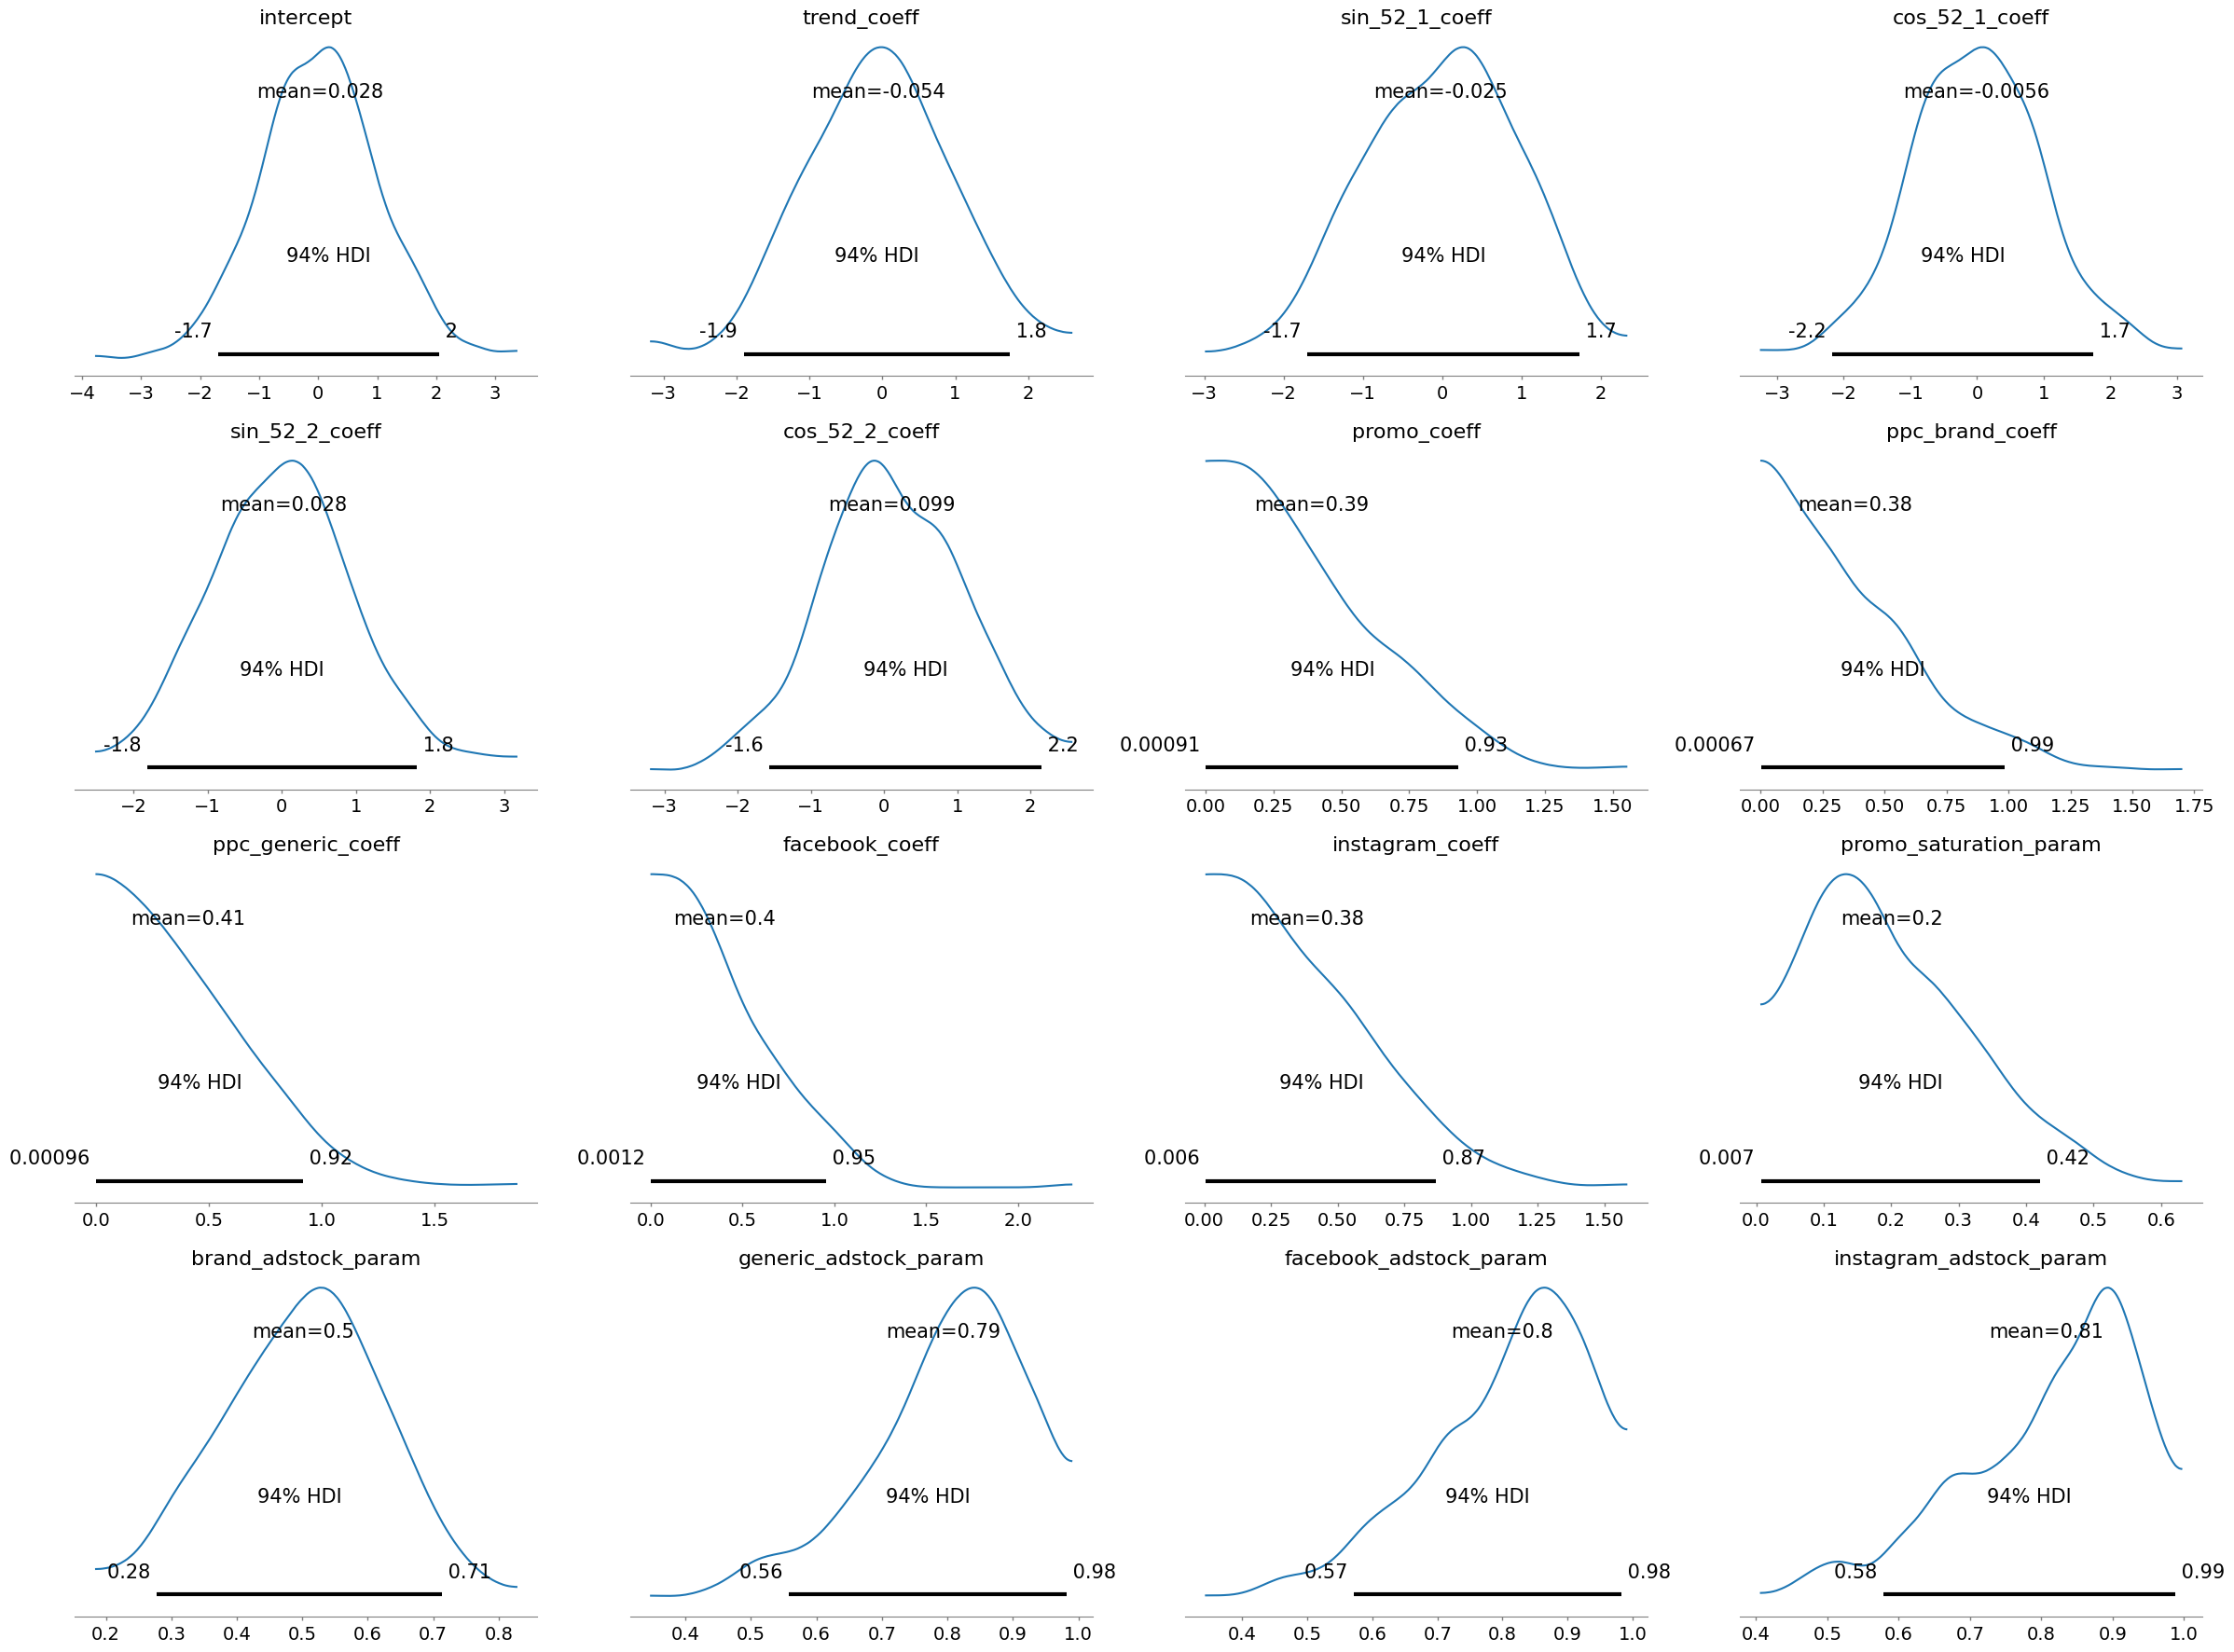

In [27]:

model_coeffs = ['intercept', 'trend_coeff', 'sin_52_1_coeff', 'cos_52_1_coeff', 'sin_52_2_coeff', 'cos_52_2_coeff', 'promo_coeff', 'ppc_brand_coeff', 'ppc_generic_coeff', 'facebook_coeff', 'instagram_coeff']
transformation_params = ['promo_saturation_param', "brand_adstock_param", "generic_adstock_param", "facebook_adstock_param", "instagram_adstock_param"]

random_seed = 123
with model:
  prior_sample = pymc.sample_prior_predictive(random_seed=random_seed)

arviz.plot_posterior(prior_sample, var_names=model_coeffs + transformation_params, group='prior');

## Train model 🧘

This function samples from the posterior distribution of the model parameters using MCMC.

The goal is to generate a set of probable parameter values given the data.

🔹 Parameter Breakdown
- draws=1_000	Number of posterior samples per chain (i.e., how many valid samples are drawn for each parameter).
- chains=4	Number of independent Markov Chains to run. Running multiple chains helps diagnose convergence.
- random_seed=random_seed	Fixes randomness for reproducibility (ensures same results across runs).


In [28]:
with model:
    model_trace = pymc.sample(draws=1_000, chains=4, random_seed=random_seed)

Output()

Output()

Output()

Output()

🔹 What Does This Return?

model_trace stores the sampled values of all the model parameters.

It is an ArviZ InferenceData object, which contains:

- trace.posterior: The posterior samples of all parameters.
- trace.sample_stats: Information about sampling diagnostics (like acceptance rates).
- trace.constant_data: the features data
- trace.observed_data: the observed target

In [29]:
model_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

#### Check Posterior 🧐

**Bayesian Diagnostics Metrics**


R-hat evaluates whether the chains in your MCMC sampling have converged. It compares the variance within each chain to the variance between chains. The formula for $\hat{R}$ is:

$$
\hat{R} = \sqrt{\frac{\hat{V}}{W}}
$$

If $(\hat{R} > 1.1)$, it suggests that the chains haven’t converged yet and might require more iterations or better tuning.

 $W$: Within-Chain Variance

$$
W = \frac{1}{m} \sum_{j=1}^m s_j^2
$$
where:
- $m$ is the number of chains.
- $s_j^2$ is the variance of samples within chain \( j \).

It measures the **average variance within individual chains** and it does not account for variability between chains.

\


$B$: Between-Chain Variance
The between-chain variance, $B$, captures the variability of the means across chains:
$$
B = \frac{n}{m-1} \sum_{j=1}^m (\bar{\theta}_j - \bar{\theta})^2
$$
where:
- $\bar{\theta}_j$ is the mean of chain \( j \).
- $\bar{\theta}$ is the overall mean of all chains
- $n$ represents the number of iterations (samples) within each chain

it detects differences between chains, which may indicate lack of convergence.

\

$\hat{V}$: Posterior Variance Estimate
$$
\hat{V} = \frac{n-1}{n} W + \frac{1}{n} B
$$

 It includes $B$, which quantifies differences between chains. If chains have not converged, \( B \) will be large, and \( \hat{V} \) will appropriately reflect the increased uncertainty.

\

*An Analogy*
- $W$: Imagine you measure the spread of test scores **within individual classrooms** in a school. You average these spreads across all classrooms. This tells you the variability within classrooms but ignores differences between classrooms.
- $\hat{V}$: Now, also consider the variability in average scores **between classrooms**. By combining this with the within-classroom variability, you get a more accurate picture of the total variability in the school.

\
*Sum Up*
- When chains **have not converged**, $B$ is large, and $W$ underestimates the total posterior variance.
- When chains **have converged**, $B \approx 0$, and $\hat{V} \approx W$

\


---

\


**Effective Sample Size (ESS)**

ESS adjusts the number of samples based on how correlated they are. High autocorrelation means fewer “effective” samples, even if we run many iterations. There are two types of ESS:
1. **Bulk ESS $(ESS_{\text{bulk}})$:** This evaluates the central (bulk) part of the posterior distribution.
2. **Tail ESS $(ESS_{\text{tail}})$:** This measures how well the extreme (tail) values are sampled.


$$
ESS \approx \frac{N}{1 + 2 \sum_{k=1}^\infty \rho_k}
$$

Where:
- $N$: The total number of iterations (samples)
- $\rho_k$: The autocorrelation at lag \(k\).

If $\rho_k$ is high (chains are not mixing well), the ESS will drop.

If ESS > 400 is generally good. High ESS means we’re capturing enough independent samples from the posterior. With low ESS  values (e.g., below 100) means we need to improve mixing, possibly by reparameterizing the model or increasing the number of iterations.



**Why These Metrics Matter**

1. **R-hat tells us:** Whether our chains are converging and exploring the same posterior distribution.
2. **ESS tells us:** How much independent information we have to make robust inferences about the parameters.





In [30]:
params_posterior_df = arviz.summary(model_trace, round_to=5, var_names=model_coeffs + transformation_params)
params_posterior_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.15056,0.08594,-0.31300,-0.00569,0.00250,0.00182,1299.76969,1792.44301,1.00371
trend_coeff,0.11458,0.03986,0.04164,0.19370,0.00090,0.00065,1964.69954,2608.52700,1.00025
sin_52_1_coeff,0.02063,0.02156,-0.01706,0.06396,0.00040,0.00031,2890.03487,2604.68542,1.00048
cos_52_1_coeff,-0.20191,0.02625,-0.25240,-0.15459,0.00053,0.00038,2423.87583,2487.56775,1.00008
sin_52_2_coeff,0.02793,0.02300,-0.01617,0.07076,0.00047,0.00033,2432.91591,2121.04827,1.00079
cos_52_2_coeff,0.10115,0.02198,0.05918,0.14116,0.00043,0.00030,2668.46456,2424.03699,1.00201
promo_coeff,0.53512,0.09186,0.37082,0.71051,0.00243,0.00175,1501.27434,1860.54095,1.00194
ppc_brand_coeff,0.03219,0.02759,0.00002,0.08444,0.00045,0.00032,2686.09262,1931.37941,1.00196
ppc_generic_coeff,0.02684,0.02905,0.00002,0.08478,0.00092,0.00065,1159.67182,1585.33452,1.00420
facebook_coeff,0.08282,0.05015,0.00002,0.16199,0.00169,0.00120,731.40130,480.85908,1.00598


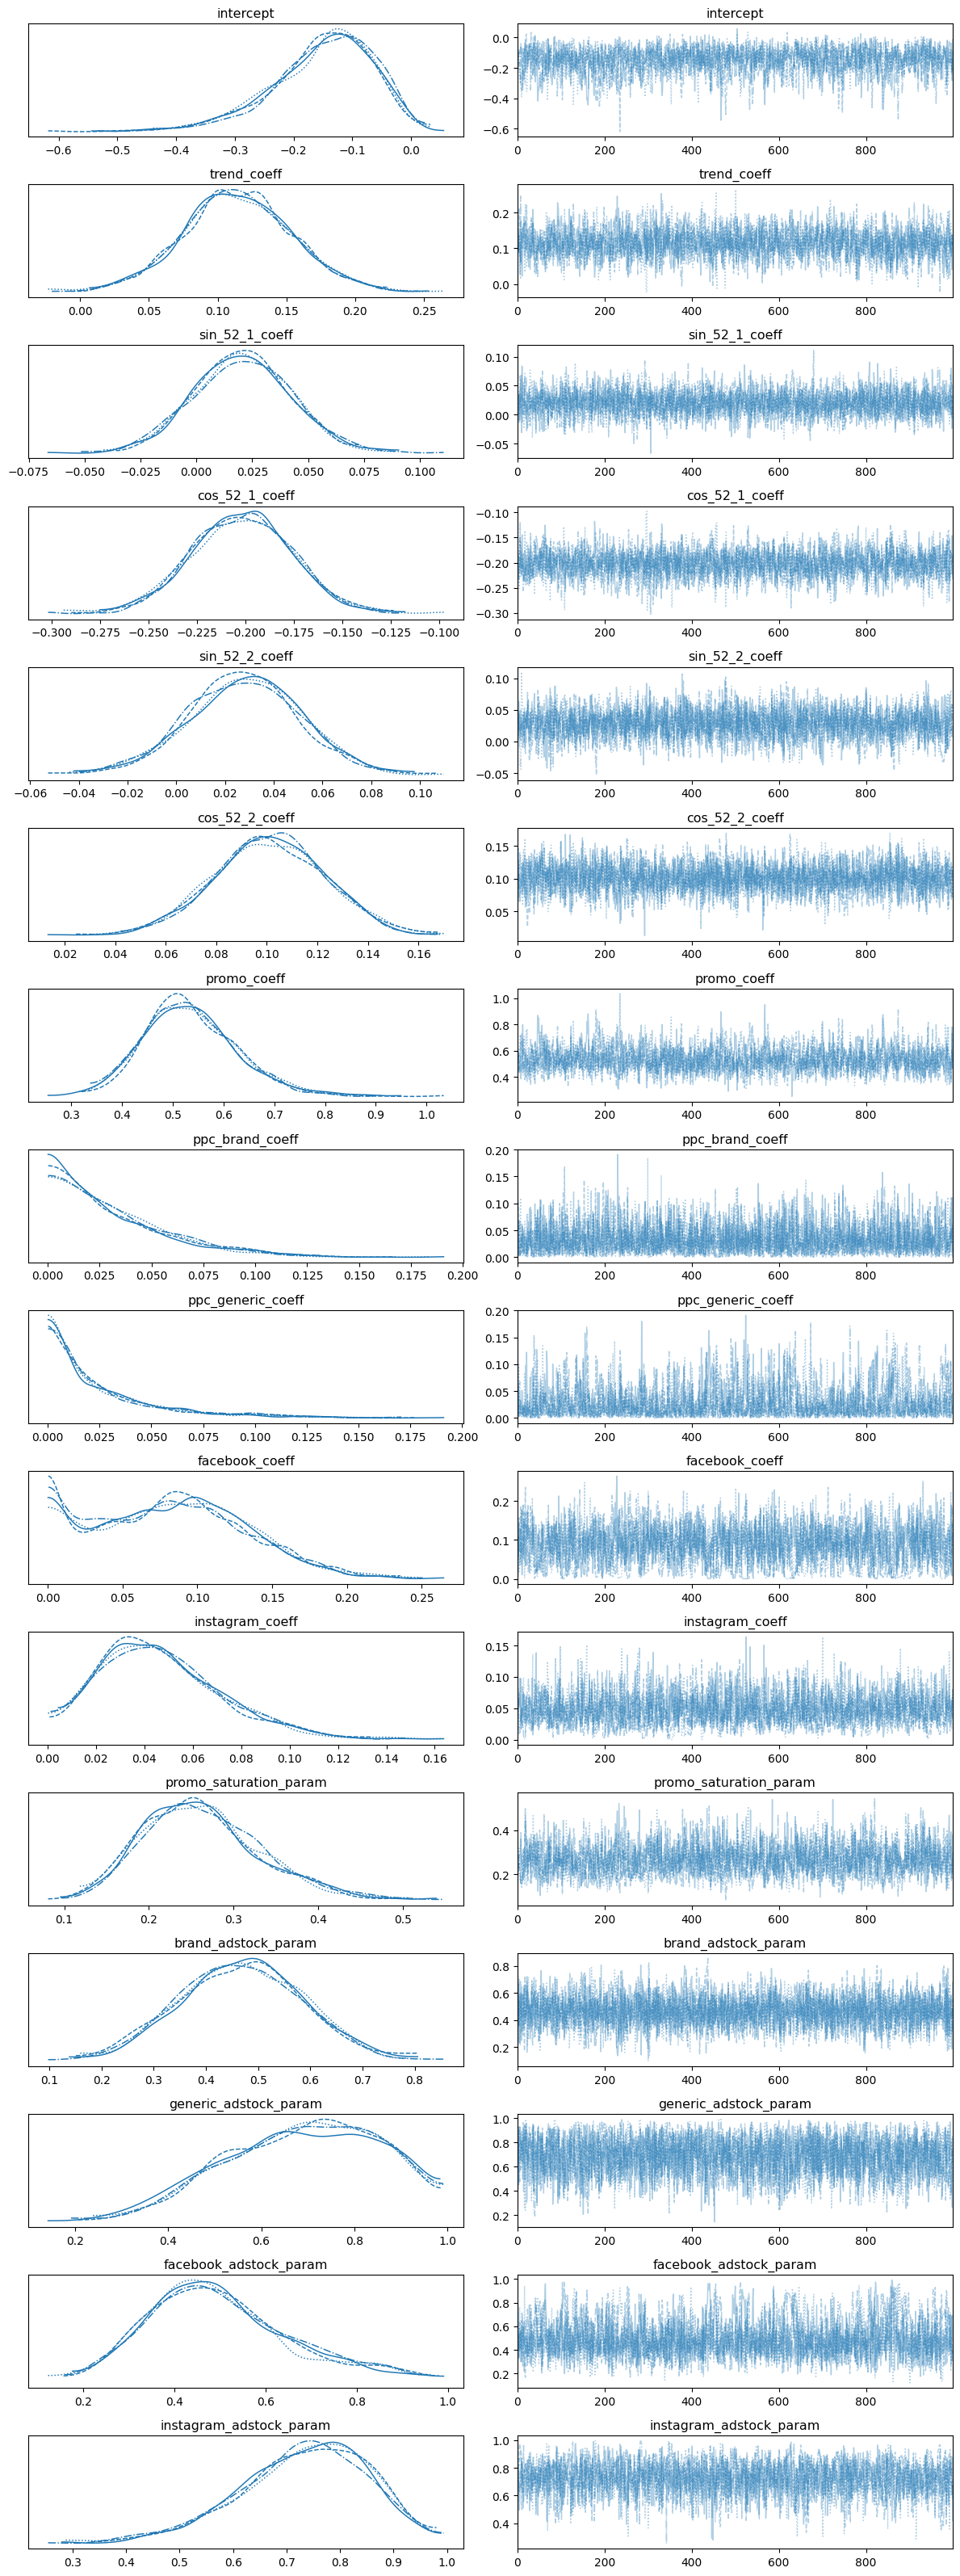

In [31]:
arviz.plot_trace(model_trace, var_names=model_coeffs + transformation_params)
plt.tight_layout()

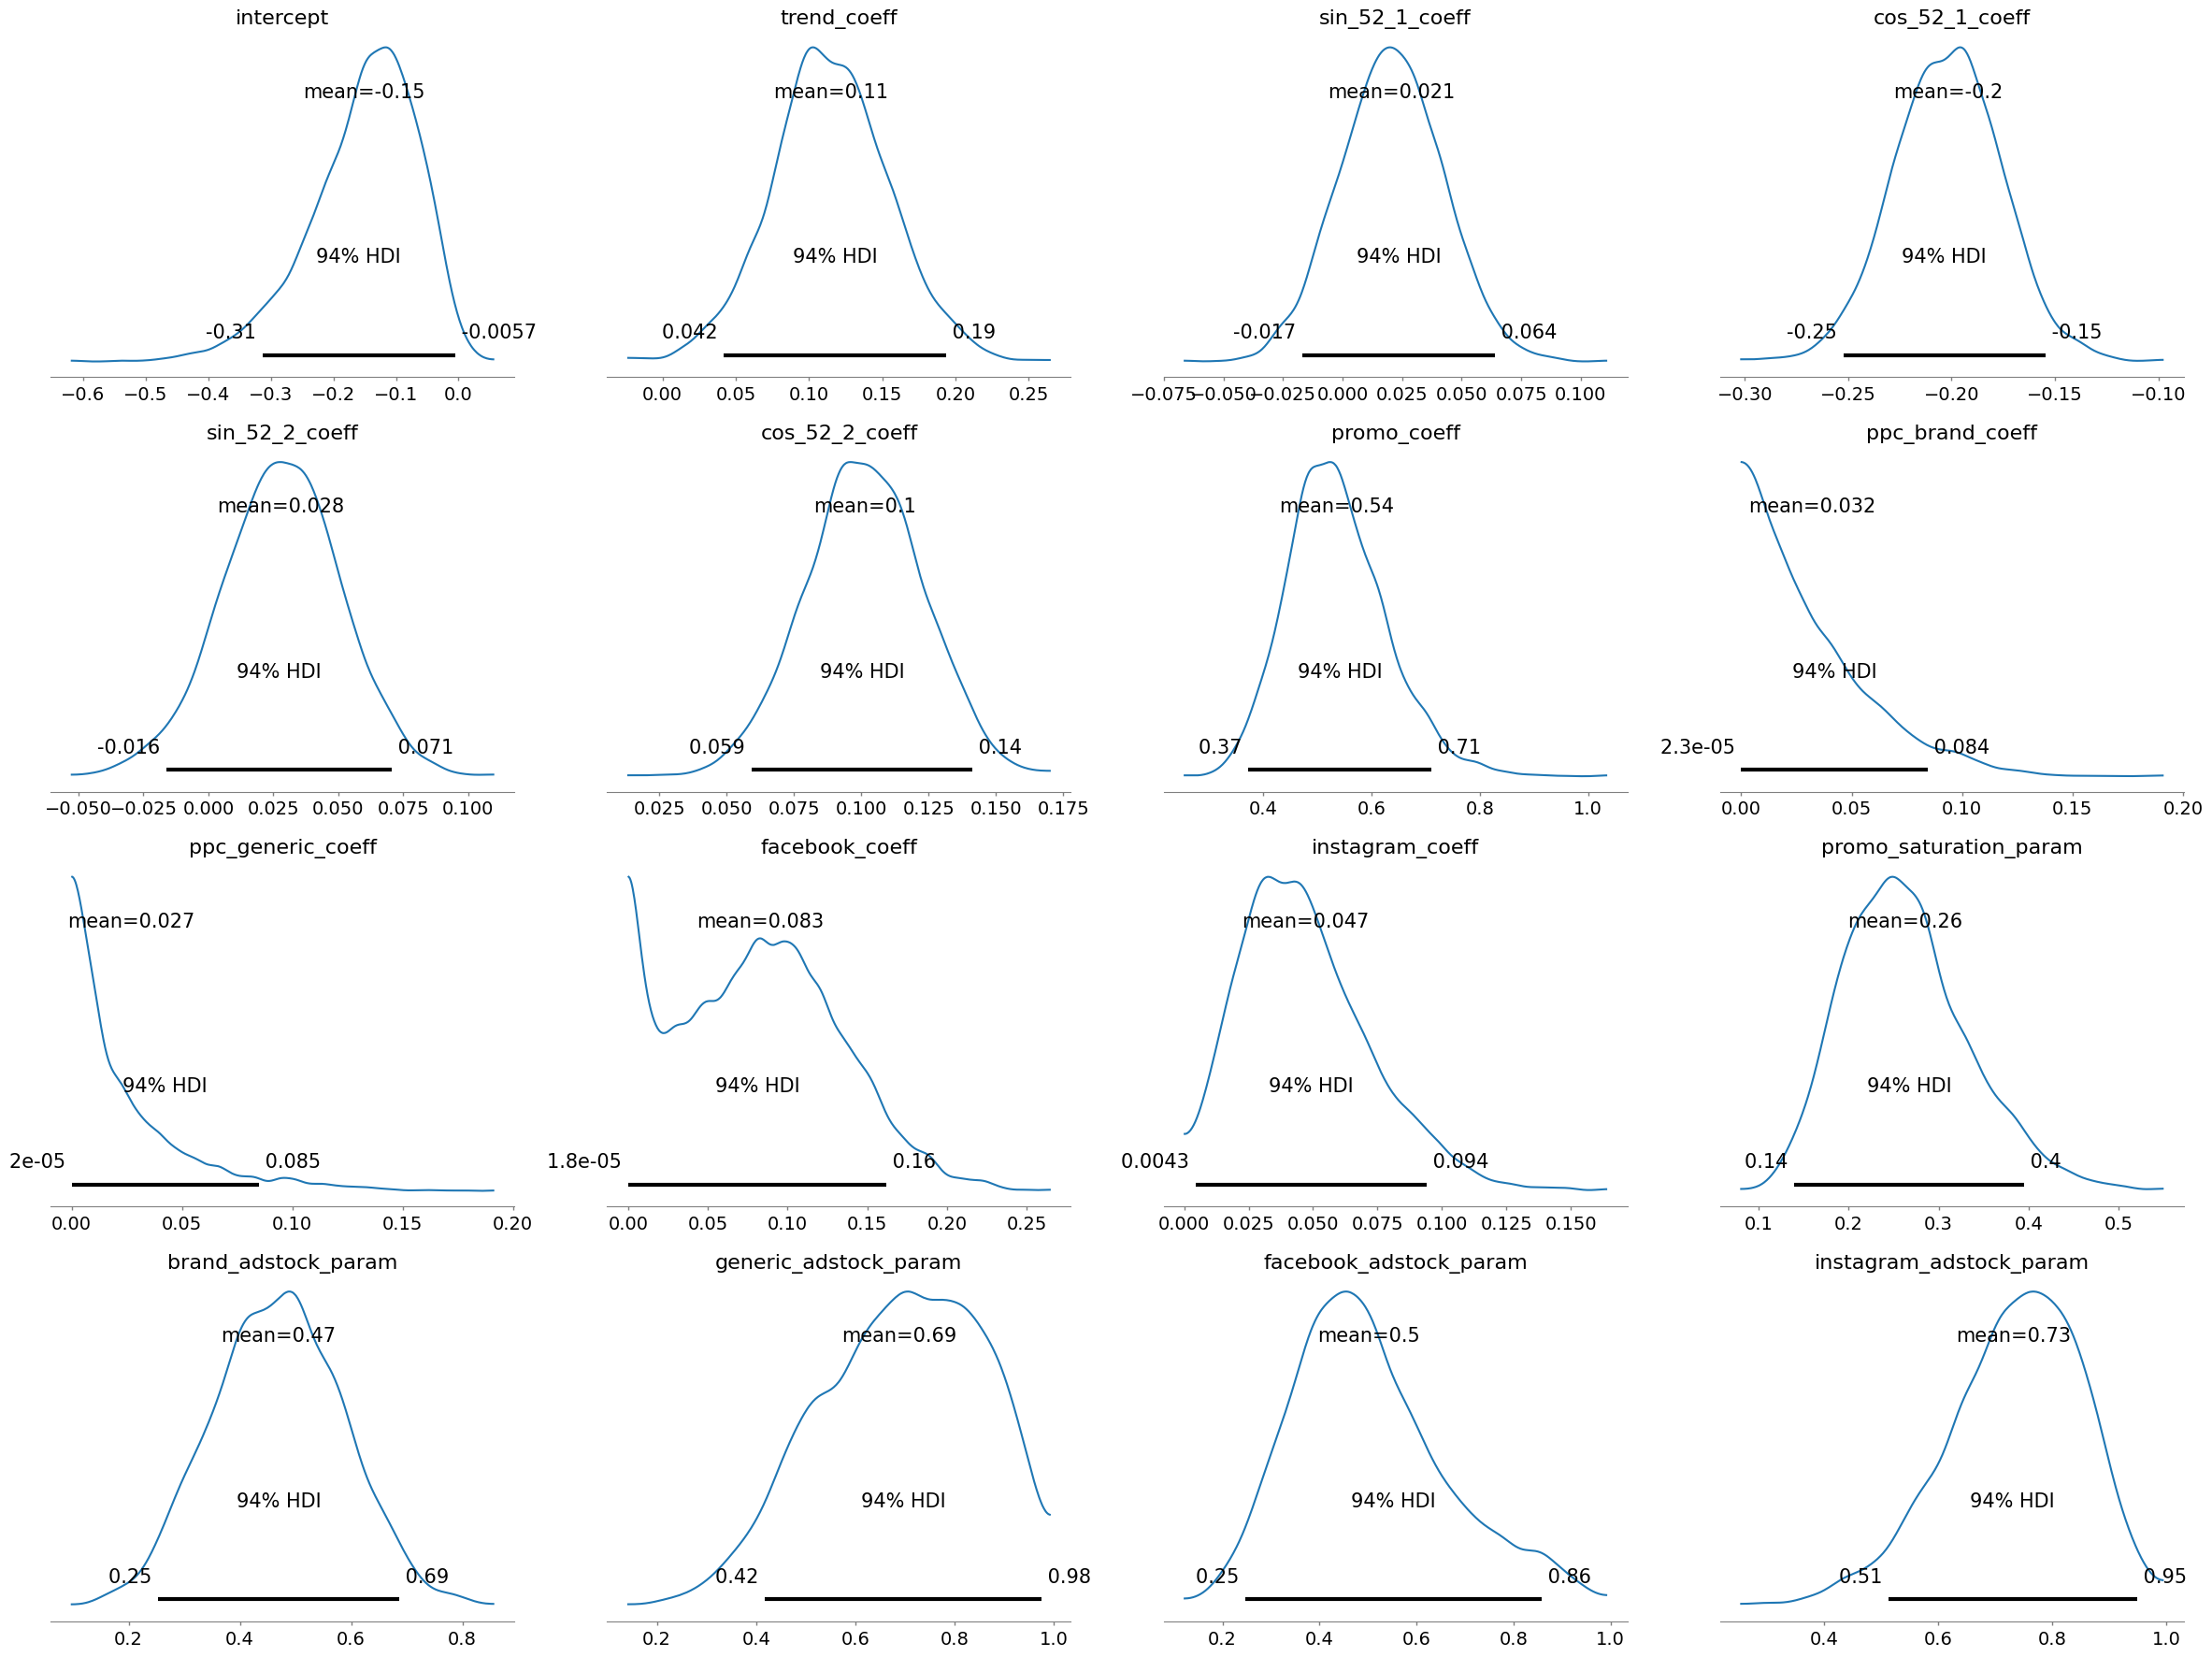

In [32]:
arviz.plot_posterior(model_trace, var_names=model_coeffs + transformation_params);

## In Sample Evaluation 🧪

In [49]:
import re

col_to_data_name = {col: col.replace('_standardized', '') for col in set(st_raw_regressors).difference(set(st_channels))}

col_to_data_name.update({
    col: re.sub(r'_lag\d+|_standardized', '', col) for col in st_channels
})

col_to_data_name

{'sin_52_2_standardized': 'sin_52_2',
 'time_standardized': 'time',
 'sin_52_1_standardized': 'sin_52_1',
 'cos_52_1_standardized': 'cos_52_1',
 'cos_52_2_standardized': 'cos_52_2',
 'promo_lag0_standardized': 'promo',
 'ppc_brand_lag0_standardized': 'ppc_brand',
 'ppc_generic_lag3_standardized': 'ppc_generic',
 'facebook_lag2_standardized': 'facebook',
 'instagram_lag6_standardized': 'instagram'}

In [50]:
def predict(model, trace, data_df,
            target_col: str,
            date_col: str,
            col_to_name_dict: dict[str, str]) -> pl.DataFrame:
  with model:
    for col_name, model_name in col_to_name_dict.items():
      model.set_data(model_name, data_df[col_name].to_list())
    predition_trace = pymc.sample_posterior_predictive(trace, model, var_names=[target_col], predictions=True, random_seed=random_seed)
    predictions_mean = predition_trace['predictions'][target_col][1].mean(axis=0)
    prediction_intervals = arviz.hdi(ary=predition_trace['predictions'], hdi_prob=0.94)[target_col]
    prediction_df = pl.DataFrame({
      'prediction_mean': list(predictions_mean),
      'prediction_hdi_3': list(prediction_intervals[:, 0]),
      'prediction_hdi_97': list(prediction_intervals[:, 1]),
      date_col: data_df[date_col]
    })
    return prediction_df


train_prediction_df = predict(model, model_trace, train_df, st_target, date_col, col_to_data_name).join(train_df, on=[date_col])


Output()

In [51]:

def plot_prediction(prediction_df: pl.DataFrame, target_col: str, date_col: str):
    prediction_df = prediction_df.to_pandas()

    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=prediction_df[date_col],
            y=prediction_df['prediction_mean'],
            mode='lines',
            name='Prediction Mean',
            line=dict(color='blue')
        )
    )

    fig.add_trace(
        go.Scatter(
            x=prediction_df[date_col],
            y=prediction_df[target_col],
            mode='lines',
            name='Actual Target',
            line=dict(color='black')
        )
    )

    fig.add_trace(
        go.Scatter(
            x=prediction_df[date_col].to_list() + prediction_df[date_col].to_list()[::-1],
            y=prediction_df['prediction_hdi_3'].to_list() + prediction_df['prediction_hdi_97'].to_list()[::-1],
            fill='toself',
            fillcolor='rgba(0, 100, 80, 0.2)',  # Adjust transparency
            line=dict(color='rgba(255,255,255,0)'),
            name='94% HDI Interval',
            showlegend=True
        )
    )

    fig.update_layout(
        title="Model Fit with Confidence Interval",
        xaxis_title="Date",
        yaxis_title=target_col,
        template="plotly_white",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    )

    fig.show()


def plot_goodness_of_fit(predoction_df: pl.DataFrame,
                         prediction_col: str,
                         actual_col: str):
  fig = px.scatter(x = predoction_df[prediction_col].to_list(), y = predoction_df[actual_col].to_list())
  max_new_customers = max(predoction_df[actual_col])
  fig.add_trace(go.Scatter(x=np.linspace(0, max_new_customers, 50), y=np.linspace(0, max_new_customers, 50), mode='lines', name='markers', line={'color':'black'}))
  fig.update_layout(title='Goodness Of Fit')
  fig.show()


def compute_metrics(prediction_df: pl.DataFrame, target_col: str) -> pl.Series:
  metrics_df = pl.DataFrame({
     'r2': r2_score(prediction_df[target_col].to_list(), prediction_df['prediction_mean'].to_list()),
     'mae': mean_absolute_error(prediction_df[target_col].to_list(), prediction_df['prediction_mean'].to_list()),
  })
  return metrics_df


train_metrics_df = compute_metrics(train_prediction_df, st_target)
plot_goodness_of_fit(train_prediction_df, 'prediction_mean', st_target)
plot_prediction(train_prediction_df, st_target, date_col)
train_metrics_df

r2,mae
f64,f64
0.898594,0.053905


## Channel Contribution 💰

We extract the contributions of each marketing channel from the posterior samples of your Bayesian model. This involves applying the learned transformation parameters (saturation and adstock effects) to the original marketing spend data using the mean estimated coefficients. The contributions are then normalized to analyze the relative impact of each channel over time. This allows for a clear interpretation of which channels drive the target outcome most effectively.

### code

In [72]:
def get_spent_props_df(df: pl.DataFrame, date_col: str, mkg_channels: list[str]) -> pl.DataFrame:
    prop_df = df.select([date_col] + mkg_channels)

    total_spend = (
        prop_df
        .group_by(date_col)
        .agg([pl.sum(col) for col in mkg_channels])
        .with_columns(pl.sum_horizontal(mkg_channels).alias("total_spend"))
    )

    spent_props = (
        total_spend
        .with_columns(
          [
              (pl.col(mkg) / pl.col("total_spend")).alias(f"{mkg}_prop") for mkg in mkg_channels
          ])
        .select([date_col] + [f"{mkg}_prop" for mkg in mkg_channels])
        .unpivot(index=["year"], variable_name="Channel", value_name="Proportion")
    )
    return spent_props

In [53]:
import pandas as pd


def root_transformation(x: np.ndarray, beta: float) -> np.ndarray:
    if not (0 < beta <= 1):
        raise ValueError("Beta must be in the range (0, 1].")
    return x**beta

def geometric_adstock(investment_series: np.typing.ArrayLike,
                      decay_rate: float) -> np.array:
    if not (0 <= decay_rate < 1):
        raise ValueError("Decay factor must be between 0 and 1.")

    transformed = np.zeros_like(investment_series)
    transformed[0] = investment_series[0]

    for i in range(1, len(investment_series)):
        transformed[i] = investment_series[i] + decay_rate * transformed[i - 1]
    return transformed


def extract_mean_coefficients(summary_df: pd.DataFrame) -> pl.DataFrame:
    coefficients_df = pl.from_pandas(summary_df.reset_index(drop=False)).select(["index", "mean"]).rename({'index': 'param'})
    return coefficients_df

In [59]:
def get_contribution_df(train_df: pl.DataFrame,
                        coeffs_series: pl.DataFrame,
                        date_col: str = date_col) -> pl.DataFrame:


    coeffs = dict(zip(coeffs_series["param"], coeffs_series["mean"]))
    contributions = {}
    contributions[date_col] = train_df[date_col]

    contributions["trend_contribution"] = (
       coeffs["trend_coeff"] * train_df["time_standardized"]
    )

    for harmonic_col in [col for col in train_df.columns if "sin_" in col or "cos_" in col]:
        harmonic_col_name = harmonic_col.replace("_standardized", "")
        contributions[f"{harmonic_col_name}_contribution"] = (
            coeffs.get(f"{harmonic_col_name}_coeff", 0) * train_df[harmonic_col]
        )

    promo_transformed = train_df["promo_lag0_standardized"] ** coeffs["promo_saturation_param"]
    contributions["promo_contribution"] = coeffs["promo_coeff"] * promo_transformed

    ppc_brand_adstocked = geometric_adstock(
        train_df["ppc_brand_lag0_standardized"].to_numpy(), coeffs["brand_adstock_param"]
    )
    contributions["ppc_brand_contribution"] = coeffs["ppc_brand_coeff"] * ppc_brand_adstocked

    ppc_generic_adstocked = geometric_adstock(
        train_df["ppc_generic_lag3_standardized"].to_numpy(), coeffs["generic_adstock_param"]
    )
    contributions["ppc_generic_contribution"] = coeffs["ppc_generic_coeff"] * ppc_generic_adstocked

    facebook_adstocked = geometric_adstock(
        train_df["facebook_lag2_standardized"].to_numpy(), coeffs["facebook_adstock_param"]
    )
    contributions["facebook_contribution"] = coeffs["facebook_coeff"] * facebook_adstocked

    instagram_adstocked = geometric_adstock(
        train_df["instagram_lag6_standardized"].to_numpy(), coeffs["instagram_adstock_param"]
    )
    contributions["instagram_contribution"] = coeffs["instagram_coeff"] * instagram_adstocked

    contributions_df = pl.DataFrame(contributions)

    return contributions_df



In [60]:


def get_normalised_contributions(contribution_df: pl.DataFrame,
                                 contribution_components: list[str],
                                 date_col: str = date_col) -> pl.DataFrame:
  contribution_df = (
      contribution_df
      .with_columns([pl.col(component).clip(lower_bound=0) for component in contribution_components])
      .with_columns(tot_sum = pl.sum_horizontal(contribution_components))
      .with_columns([(pl.col(component) / pl.col('tot_sum')).alias(component)
      for component in contribution_components])
  )




  return contribution_df.select([date_col] + contribution_components)


In [56]:
def decompose_target_on_contributions(normalised_contributions: pl.DataFrame,
                                      train_df: pl.DataFrame,
                                      target: str = target,
                                      date_col: str = date_col):

    decomposed_target = train_df.select(date_col, target).join(
        normalised_contributions, on=date_col
    )
    decomposed_target = decomposed_target.with_columns(
        [(pl.col(col) * pl.col(target)).cast(int).alias(col)
         for col in normalised_contributions.columns if col != date_col
        ]
    )
    return decomposed_target

In [57]:
def get_evolution_contribution_plot(contributions_df: pd.DataFrame,
                                    components_to_color: dict[str, str],
                                    contribution_components: list[str],
                                    date_col: str = date_col):

    fig = go.Figure()
    x = contributions_df[date_col].to_list()
    for component in contribution_components:
      fig.add_trace(go.Scatter(
        x=x,
        y=contributions_df[component],
        hoverinfo='x+y',
        mode='lines',
        name=component,
        line=dict(width=0.5, color=components_to_color[component]),
        stackgroup='one'  # define stack group
    ))



    fig.update_layout(title='Contributions to new customers acquisition')
    return fig






### results

In [73]:
channels = ['promo_lag0', 'ppc_brand_lag0', 'ppc_generic_lag3',
            'facebook_lag2', 'instagram_lag6']


props_spending_df = get_spent_props_df(
    standarised_df.with_columns(year=pl.col('Monday').dt.year()),
    date_col='year',
    mkg_channels=channels)



mean_coeffs = extract_mean_coefficients(params_posterior_df)
contributions_df = get_contribution_df(train_df, mean_coeffs)

contribution_components = ['baseline', 'promo_contribution',
                          'ppc_brand_contribution',
                          'ppc_generic_contribution',
                          'facebook_contribution',
                          'instagram_contribution']
baseline_cols = ['trend_contribution',
                 'sin_52_1_contribution',
                 'cos_52_1_contribution',
                 'sin_52_2_contribution',
                 'cos_52_2_contribution']

contributions_df = contributions_df.with_columns(baseline=pl.sum_horizontal(baseline_cols))
normalised_contributions = get_normalised_contributions(contributions_df, contribution_components)
final_contr_df = decompose_target_on_contributions(normalised_contributions, train_df, target, date_col)

In [74]:
components_to_color = {'baseline': 'blue',
                       'promo_contribution': 'red',
                        'ppc_brand_contribution': 'violet',
                        'ppc_generic_contribution': 'yellow',
                        'facebook_contribution': 'green',
                        'instagram_contribution': 'grey'}

props_yearly_df = get_spent_props_df(final_contr_df.with_columns(year=pl.col('Monday').dt.year()),
                                    date_col='year',
                                    mkg_channels=contribution_components)

fig = px.bar(props_yearly_df, x='year', y="Proportion", color="Channel", barmode='group', title='Estimated Yearly % Contribution')
fig.show()
get_evolution_contribution_plot(final_contr_df, components_to_color, contribution_components).show()
px.bar(props_spending_df, x='year', y="Proportion", color="Channel", barmode='group', title='Spent % Contribution')

senza senso, bottom promo top generic, modificare le prior per includere questa conoscenza nel modello.

bisogna limitare le promozioni, usa le distribuzioni di cui abbiam parlato prima e trova un modo per limitare le promozioni. vogliamo più ppc generic e meno promo + provare a togliere tutti i lag adstock e le saturazioni e vedere cosa cambia